In [1]:
%%capture
%run regression.ipynb

In [2]:
%pip install -q tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [4]:
# helper function calculate the r2 scores
def evaluate_model(model_name, y_test, y_pred, is_scaled=False):
    """Calculate and print R2 scores for a model"""
    r2_overall = r2_score(y_test, y_pred)
    r2_weighted = r2_score(y_test, y_pred, multioutput="variance_weighted")
    
    scale_note = " (scaled)" if is_scaled else ""
    print(f"\n{model_name} Results{scale_note}:")
    print(f"  Overall R2:  {r2_overall:.4f}")
    print(f"  Weighted R2: {r2_weighted:.4f}")
    
    return r2_overall, r2_weighted

In [5]:
def build_nn_model(input_dim, output_dim, architecture='standard'):
    """Build a neural network model with specified architecture"""
    
    if architecture == 'standard':
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(input_dim,)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(output_dim)
        ])
    elif architecture == 'wide':
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(input_dim,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(output_dim)
        ])
    elif architecture == 'deep':
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(input_dim,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(output_dim)
        ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

In [6]:
def train_model(model, X_train, y_train, epochs=500, patience=30, verbose=0):
    """Train a model with early stopping and learning rate scheduling"""
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=15,
            min_lr=1e-7
        )
    ]
    
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=128,
        verbose=verbose,
        callbacks=callbacks
    )
    
    return history

In [7]:
# prepare inverse data (nm -> V)
# Input: current positions (x_out, z_out)
# Output: voltage windows that led to those positions
X_inverse = xz_data_out  # (N, 2) - positions
y_inverse = xz_data_in   # (N, 6) - voltage windows
X_train, X_test, y_train, y_test = train_test_split(
     X_inverse, y_inverse, test_size=0.2, random_state=42
)


WINDOW_LEN = 3 # using the same window length as in regression
print(X_inverse.shape)
input_dim = X_inverse.shape[1]  # 2 (x and z positions)
output_dim = y_inverse.shape[1]  # 6 (3 x-voltage + 3 z-voltage windows)
print(input_dim, output_dim)

(359999, 2)
2 6


In [8]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
evaluate_model("Linear Regression", y_test, y_pred_lin)


Linear Regression Results:
  Overall R2:  0.3770
  Weighted R2: 0.3924


(0.37700707456416543, 0.39244021478839936)

The feedforward (voltage -> position) R2 score came out to **0.74** (which is good).
The inverse of this (position -> voltage) gives us an R2 score of **0.39**. This means the inverse mapping is fundamentally harder.

**APPROACH 1**

Training a NN with just positions and predicting the voltage window.

In [9]:
X_scaled = StandardScaler().fit_transform(X_inverse)
y_scaled = StandardScaler().fit_transform(y_inverse)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

model = build_nn_model(X_train_scaled.shape[1], y_train_scaled.shape[1])
history = train_model(model, X_train_scaled, y_train_scaled, verbose=0)

y_pred = model.predict(X_test_scaled, verbose=0)
evaluate_model("Neural Network", y_test_scaled, y_pred, is_scaled=True)


Neural Network Results (scaled):
  Overall R2:  0.4249
  Weighted R2: 0.4252


(0.4248596672670364, 0.42518946718646894)

**APPROACH 2**

Create a feature vector containing the current state and previous 2 states
 
 `[ x(t−2), x(t−1), x(t), z(t−2), z(t−1), z(t) ]`

This way the network has more information about the previous states - not just the current state

In [10]:
x_out = df["x_out"].values.reshape(-1, 1)
z_out = df["z_out"].values.reshape(-1, 1)

# create position windows...
x_out_window = sliding_window_view(x_out, WINDOW_LEN, 0).squeeze()
z_out_window = sliding_window_view(z_out, WINDOW_LEN, 0).squeeze()

xz_out_window = np.concatenate([x_out_window, z_out_window], axis=1)

print(f"Original input (position only): {xz_data_out.shape}")
print(f"New input (position history): {xz_out_window.shape}")

# Now input and output have same length and meaning
X_inverse_history = xz_out_window  # (N, 6) - position windows
y_inverse = xz_data_in             # (N, 6) - voltage windows

Original input (position only): (359999, 2)
New input (position history): (359999, 6)


In [11]:
# Linear Regression
X_train, X_test, y_train, y_test = train_test_split(
    X_inverse_history, y_inverse, test_size=0.2, random_state=42
)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
r2_lin, _ = evaluate_model("Linear Regression", y_test, y_pred_lin)


Linear Regression Results:
  Overall R2:  0.4847
  Weighted R2: 0.4980


In [12]:
# Neural Network
X_scaled = StandardScaler().fit_transform(X_inverse_history)
y_scaled = StandardScaler().fit_transform(y_inverse)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

model = build_nn_model(X_train_scaled.shape[1], y_train_scaled.shape[1])
history = train_model(model, X_train_scaled, y_train_scaled, verbose=0)

y_pred = model.predict(X_test_scaled, verbose=0)
r2_nn, _ = evaluate_model("Neural Network", y_test_scaled, y_pred, is_scaled=True)


Neural Network Results (scaled):
  Overall R2:  0.6398
  Weighted R2: 0.6400


**APPROACH 3**

Increase the size of the feature vector by adding velocity and acceleration.

In [13]:
# Calculate velocity and acceleration
x_out_full = df["x_out"].values
z_out_full = df["z_out"].values

x_velocity = np.gradient(x_out_full)
z_velocity = np.gradient(z_out_full)
x_acceleration = np.gradient(x_velocity)
z_acceleration = np.gradient(z_velocity)

# Truncate to match window length
x_vel_truncated = x_velocity[WINDOW_LEN-1:]
z_vel_truncated = z_velocity[WINDOW_LEN-1:]
x_acc_truncated = x_acceleration[WINDOW_LEN-1:]
z_acc_truncated = z_acceleration[WINDOW_LEN-1:]

X_inverse_history = np.column_stack([
    xz_out_window,
    x_vel_truncated,
    z_vel_truncated,
    x_acc_truncated,
    z_acc_truncated
])

print(X_inverse_history.shape)

(359999, 10)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_inverse_history, y_inverse, test_size=0.2, random_state=42
)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
r2_lin_, _ = evaluate_model("Linear Regression", y_test, y_pred_lin)


Linear Regression Results:
  Overall R2:  0.4896
  Weighted R2: 0.5027


In [15]:
X_scaled = StandardScaler().fit_transform(X_inverse_history)
y_scaled = StandardScaler().fit_transform(y_inverse)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

model = build_nn_model(X_train_scaled.shape[1], y_train_scaled.shape[1])
history = train_model(model, X_train_scaled, y_train_scaled, 
                     epochs=1000, patience=50, verbose=0)

y_pred = model.predict(X_test_scaled, verbose=0)
r2_nn_, _ = evaluate_model("Neural Network", y_test_scaled, y_pred, is_scaled=True)


Neural Network Results (scaled):
  Overall R2:  0.9545
  Weighted R2: 0.9545


In [16]:
# train a wide model too:  [Input -> 128 -> 128 -> Output]
model = build_nn_model(X_train_scaled.shape[1], y_train_scaled.shape[1], architecture="wide")
history = train_model(model, X_train_scaled, y_train_scaled,
                      epochs=1000, patience=50, verbose=0)

y_pred = model.predict(X_test_scaled, verbose=0)
r2_wide_nn, _ = evaluate_model("Wide Neural Network", y_test_scaled, y_pred, is_scaled=True)


Wide Neural Network Results (scaled):
  Overall R2:  0.9538
  Weighted R2: 0.9538


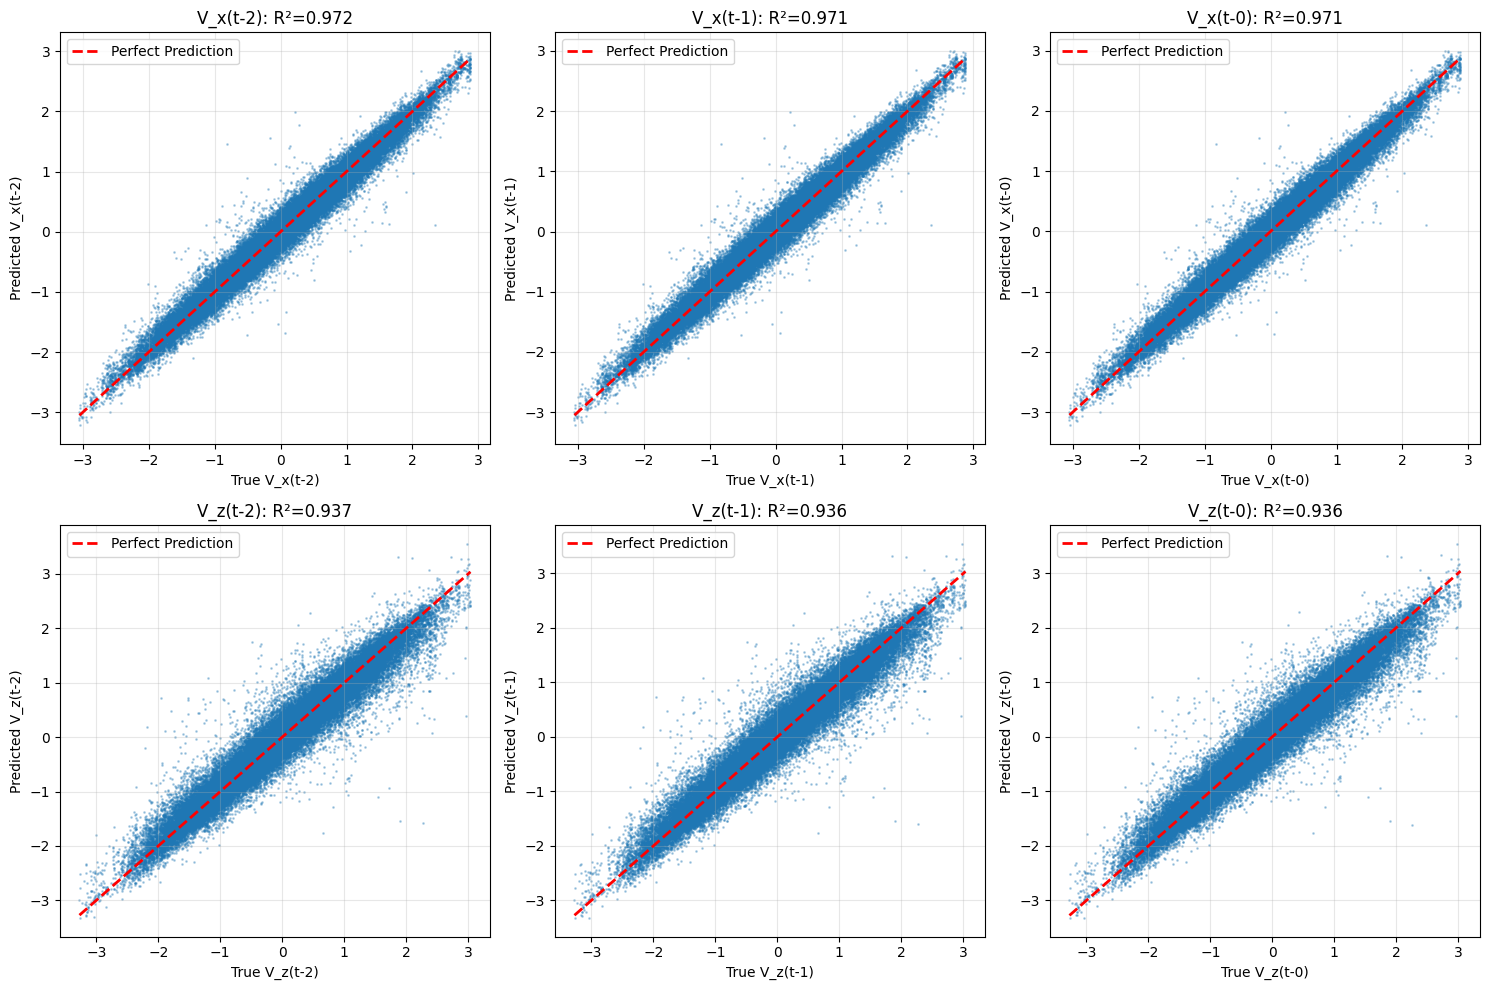

In [17]:
# some visualisation
# Prediction vs True plot

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(min(6, y_test_scaled.shape[1])):
    # looping over the Voltage output values...
    ax = axes[i]
    ax.scatter(y_test_scaled[:, i], y_pred[:, i], alpha=0.3, s=1)
    ax.plot([y_test_scaled[:, i].min(), y_test_scaled[:, i].max()],
            [y_test_scaled[:, i].min(), y_test_scaled[:, i].max()],
            'r--', lw=2, label='Perfect Prediction')
    
    r2_individual = r2_score(y_test_scaled[:, i], y_pred[:, i])
    
    output_name = f"V_x(t-{2-i%3})" if i < 3 else f"V_z(t-{2-(i-3)%3})"
    ax.set_xlabel(f'True {output_name}')
    ax.set_ylabel(f'Predicted {output_name}')
    ax.set_title(f'{output_name}: R²={r2_individual:.3f}')
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()